## Imports

In [ ]:
import pandas as pd

import jax.numpy as jnp
from jax import random, vmap

!pip3 install numpyro
import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

!pip3 install arviz
import arviz as az
import matplotlib.pyplot as plt

     |████████████████████████████████| 264 kB 28.0 MB/s 


/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


## 4.1

Here uniform is chosen instead off the binomial bcoz the author assumes each step may not be perfect 1 yard. so it can be b/w 0 - 1 yard (left or right). Thus uniform distribution (1, -1)

In [ ]:
dunif = dist.Uniform(-1, 1)
key = random.PRNGKey(0)
samples = dunif.sample(key, (1000, 16))
pos = jnp.sum(samples, -1)

## 4.2

In [ ]:
dunif = dist.Uniform(0, 0.1)
growthsamples = jnp.prod(1 + dunif.sample(key, (10000, 12)), -1)
growthsamples.shape

(10000,)

## 4.3

Log probability bcoz probly its faster. End result is just the probability of each data point assuming they are sampled from a normal dist

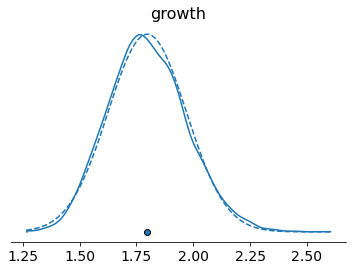

In [ ]:
az.plot_density({'growth': growthsamples}, hdi_prob=1)
x = jnp.sort(growthsamples)
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")
plt.show()

## 4.4

In [ ]:
big = jnp.prod(1 + dist.Uniform(0, 0.5).sample(key, (10000, 12)), -1)
small = jnp.prod(1 + dist.Uniform(0, 0.01).sample(key, (10000, 12)), -1)
big, small

(DeviceArray([18.742033 , 11.604453 , 19.078642 , ...,  7.5537906,
              11.295802 , 23.21978  ], dtype=float32),
 DeviceArray([1.0708382, 1.0577757, 1.0716889, ..., 1.0464755, 1.0573572,
              1.076675 ], dtype=float32))

## 4.5

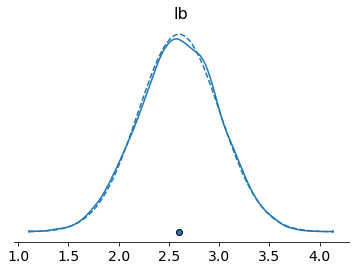

In [ ]:
logbig = jnp.log(big)
az.plot_density({'lb': logbig}, hdi_prob=1)
x = jnp.sort(logbig)
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")
plt.show()

## 4.6

In [ ]:
w, n = 6, 9
pgrid = jnp.linspace(0, 1, 100)
probbin = jnp.exp(dist.Binomial(n, pgrid).log_prob(w))
post = probbin * jnp.exp(dist.Uniform(0, 1).log_prob(pgrid))
post = post / jnp.sum(post)

## 4.7 - 4.11

In [ ]:
d = pd.read_csv('https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/Howell1.csv', delimiter=';')
print(d.info())
d.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB
None


,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [ ]:
d2 = d[d.age >= 18]
d2

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
534,162.560,47.031821,27.0,0
537,142.875,34.246196,31.0,0
540,162.560,52.163080,31.0,1
541,156.210,54.062496,21.0,0


## 4.12

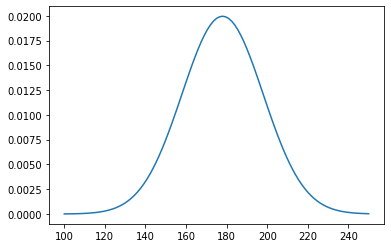

In [ ]:
x = jnp.linspace(100, 250, 101)
plt.plot(x, jnp.exp(dist.Normal(178, 20).log_prob(x)))
plt.show()

## 4.13

/usr/local/lib/python3.7/dist-packages/numpyro/distributions/distribution.py:293: UserWarning: Out-of-support values provided to log prob method. The value argument should be within the support.
  "Out-of-support values provided to log prob method. "


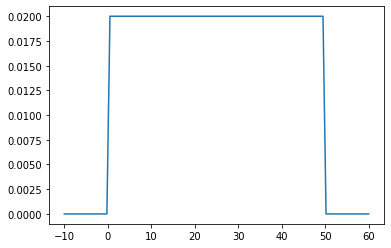

In [ ]:
x = jnp.linspace(-10, 60, 101)
plt.plot(x, jnp.exp(dist.Uniform(0, 50, validate_args=True).log_prob(x)))
plt.show()

## 4.14

In [ ]:
samplemu = dist.Normal(178, 20).sample(key, (10000,))
priorh = dist.Normal(samplemu, samplestd)
priorh.sample(key).shape

NameError: ignored

## 4.15

In [ ]:
sample_mu = dist.Normal(178, 100).sample(random.PRNGKey(0), (int(1e4),))
samplestd = dist.Uniform(0, 50).sample(random.PRNGKey(1), (10000,))
prior_h = dist.Normal(sample_mu, samplestd).sample(random.PRNGKey(2))
az.plot_kde(prior_h)
plt.show()

## 4.16

Meshgrid returns 2 vars. Now if u iterate thru them, ull get coordinate like results (if not razed, then batch like).

If you use
the obvious approach, like exp(post\$prod ), you’ll get a vector full of zeros, which isn’t very helpful. This
is a result of R’s rounding very small probabilities to zero. Remember, in large samples, all unique samples are
unlikely. This is why you have to work with log-probability. The code in the box dodges this problem by scaling
all of the log-products by the maximum log-product. As a result, the values in post$prob are not all zero, but
they also aren’t exactly probabilities. Instead they are relative posterior probabilities. But that’s good enough for
what we wish to do with these values.

In [ ]:
mulist = jnp.linspace(150, 160, 100)
siglist = jnp.linspace(7, 9, 100)
mesh = jnp.meshgrid(mulist, siglist)
post = {'mu': mesh[0].reshape(-1), 'std': mesh[1].reshape(-1)}
post['LL'] = vmap(lambda mu, sigma: jnp.sum(dist.Normal(mu, sigma).log_prob(d2.height.values)))(post['mu'], post['std'])
lmu = dist.Normal(178, 20).log_prob(post['mu'])
lstd = dist.Uniform(0, 50).log_prob(post['std'])
post['prob'] = post['LL'] + lmu + lstd
post['prob'] = jnp.exp(post['prob'] - jnp.max(post['prob']))
post['prob']

## 4.17 - 4.18

In [ ]:
plt.imshow(
    post["prob"].reshape(100, 100),
    origin="lower",
    extent=(150, 160, 7, 9),
    aspect="auto",
)
plt.show()

## 4.19

Dist Categorical is like sampling with replacement ... til n

In [ ]:
prob = post['prob'] / jnp.sum(post['prob'])
samplerows = dist.Categorical(probs=prob).sample(key, (10000,))
smu = post['mu'][samplerows]
sstd = post['std'][samplerows]
sstd

## 4.20

In [ ]:
plt.scatter(smu, sstd, s=64, alpha=0.1, edgecolor="none")
plt.show()

## 4.21 - 4.22

In [ ]:
az.plot_kde(smu)
plt.show()
az.plot_kde(sstd)
plt.show()
print(hpdi(smu, 0.89))
print(hpdi(sstd, 0.89))

## 4.23 - 4.25

Right tail longer for std bcoz it can never be negative (its only one of the reason tho)

In [ ]:
d3 = d2.height.sample(20)
mu_list = jnp.linspace(start=150, stop=170, num=200)
sigma_list = jnp.linspace(start=4, stop=20, num=200)
mesh = jnp.meshgrid(mu_list, sigma_list)
post2 = {"mu": mesh[0].reshape(-1), "sigma": mesh[1].reshape(-1)}
post2["LL"] = vmap(
    lambda mu, sigma: jnp.sum(dist.Normal(mu, sigma).log_prob(d3.values))
)(post2["mu"], post2["sigma"])
logprob_mu = dist.Normal(178, 20).log_prob(post2["mu"])
logprob_sigma = dist.Uniform(0, 50).log_prob(post2["sigma"])
post2["prob"] = post2["LL"] + logprob_mu + logprob_sigma
post2["prob"] = jnp.exp(post2["prob"] - jnp.max(post2["prob"]))
prob = post2["prob"] / jnp.sum(post2["prob"])
sample2_rows = dist.Categorical(probs=prob).sample(random.PRNGKey(0), (int(1e4),))
sample2_mu = post2["mu"][sample2_rows]
sample2_sigma = post2["sigma"][sample2_rows]
plt.scatter(sample2_mu, sample2_sigma, s=64, alpha=0.1, edgecolor="none")
plt.show()
az.plot_kde(sample2_sigma)
x = jnp.sort(sample2_sigma)
plt.plot(x, jnp.exp(dist.Normal(jnp.mean(x), jnp.std(x)).log_prob(x)), "--")
plt.show()

## 4.26 - 4.29

flist is the model

it seems the m4_1 is the quap approx or guide

RN treat it as blackbox

In [ ]:
def flist(height=None):
    mu = numpyro.sample("mu", dist.Normal(178, 20), rng_key=key)
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50), rng_key=key)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

In [ ]:
m4_1 = AutoLaplaceApproximation(flist)
svi = SVI(flist, m4_1, optim.Adam(1), Trace_ELBO(), height=d2.height.values)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_1 = svi_result.params

In [ ]:
samples = m4_1.sample_posterior(random.PRNGKey(1), p4_1, (1000,))
print_summary(samples, 0.89, False)

## 4.30

In [ ]:
start = {"mu": d2.height.mean(), "sigma": d2.height.std()}
m4_1 = AutoLaplaceApproximation(flist, init_loc_fn=init_to_value(values=start))
svi = SVI(flist, m4_1, optim.Adam(0.1), Trace_ELBO(), height=d2.height.values)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_1 = svi_result.params

## 4.31

In [ ]:
def model(height):
    mu = numpyro.sample("mu", dist.Normal(178, 0.1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m4_2, optim.Adam(1), Trace_ELBO(), height=d2.height.values)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_2 = svi_result.params
samples = m4_2.sample_posterior(random.PRNGKey(1), p4_2, (1000,))
print_summary(samples, 0.89, False)

## 4.32 

In [ ]:
SP = m4_1.sample_posterior(key, p4_1, (1000,))
vcov = jnp.cov(jnp.stack(list(SP.values()), axis=0))
vcov

## 4.33

In [ ]:
var = jnp.diag(vcov)
corr = vcov / jnp.sqrt(jnp.outer(var, var))
print(var)
print(corr)

## 4.34 - 4.35

In [ ]:
post = m4_1.sample_posterior(key, p4_1, (1000,))
print_summary(post, 0.89, False)

## 4.36

In [ ]:
flat = jnp.stack(list(post.values()))
print(flat.shape)
mu, sigma = jnp.mean(flat, axis=1), jnp.cov(flat)
print(mu)
print(sigma)
PD = dist.MultivariateNormal(mu, sigma).sample(key, (1000,))
PD

## 4.37

In [ ]:
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"))
plt.show()

## 4.38

expand is like setting up individual sample size
and numpyro sample returns a single sample

In [ ]:
with numpyro.handlers.seed(rng_seed=2971):
    N = 100
    a = numpyro.sample("a", dist.Normal(178, 20).expand([N]))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([N]))
b

## 4.39

In [ ]:
plt.subplot(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(-100, 400),
    xlabel='weight',
    ylabel='height'
)

plt.axhline(y=0, c="k", ls="--")
plt.axhline(y=272, c="k", ls="-", lw=0.5)
plt.title("b ~ Normal(0, 10)")
xbar = d2.weight.mean()
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)

for i in range(N):
    plt.plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2)
plt.show()

## 4.40

In [ ]:
b = dist.LogNormal(0, 1).sample(key, (1000,))
az.plot_kde(b)
plt.show()

## 4.41

In [ ]:
with numpyro.handlers.seed(rng_seed=2971):
    N = 100  # 100 lines
    a = numpyro.sample("a", dist.Normal(178, 20).expand([N]))
    b = numpyro.sample("b", dist.LogNormal(0, 1).expand([N]))

## 4.42

In [ ]:
 xbar = d2.weight.mean()
 def model(weight, height):
     a = numpyro.sample('a', dist.Normal(178, 20))
     b = numpyro.sample('b', dist.LogNormal(0, 1))
     sigma = numpyro.sample('sigma', dist.Uniform(0, 50))
     mu = numpyro.deterministic('mu', a + b * (weight - xbar))
     numpyro.sample('height', dist.Normal(mu, sigma), obs=height)

m4_3 = AutoLaplaceApproximation(model)

svi = SVI(model, m4_3, optim.Adam(1), Trace_ELBO(), weight=d2.weight.values, height=d2.height.values)
p4_3 = svi.run(key, 2000).params

## 4.43

In [ ]:
def model(weight, height):
    a = numpyro.sample('a', dist.Normal(178, 20))
    log_b = numpyro.sample('log_b', dist.Normal(0, 1))
    sigma = numpyro.sample('sigma', dist.Uniform(0, 50))
    mu = numpyro.deterministic('mu', a + jnp.exp(log_b) * (weight - xbar))
    numpyro.sample('height', dist.Normal(mu, sigma), obs=height)

m4_3b = AutoLaplaceApproximation(model)
svi = SVI(model, m4_3b, optim.Adam(1), Trace_ELBO(), weight=d2.weight.values, height=d2.height.values)
p4_3b = svi.run(key, 2000).params

## 4.44

In [ ]:
samples = m4_3.sample_posterior(key, p4_3, (1000,))
samples.pop('mu')
print_summary(samples, 0.89, False)

## 4.45

In [ ]:
vcov = jnp.cov(jnp.stack(list(samples.values()), axis=0))
jnp.round(vcov, 3)

## 4.46

In [ ]:
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"))
post = m4_3.sample_posterior(key, p4_3, (1000,))
amap, bmap = jnp.mean(post['a']), jnp.mean(post['b'])
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
plt.plot(x, amap + bmap * (x - xbar), 'k')
plt.show()

## 4.47

In [ ]:
{k:v[:5] for k, v in post.items()}

## 4.48

In [ ]:
d10 = d2[:10]

def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 50))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + b * (weight - jnp.mean(weight))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

m10 = AutoLaplaceApproximation(model)

svi = SVI(model, m10, optim.Adam(1), Trace_ELBO(), weight=d10.weight.values, height=d10.height.values)
p10 = svi.run(key, 1000).params


## 4.49

In [ ]:
post = m10.sample_posterior(key, p10, (20, ))

ax = az.plot_pair(d10[["weight", "height"]].to_dict(orient="list"))
ax.set(
    xlim=(d2.weight.min(), d2.weight.max()),
    ylim=(d2.height.min(), d2.height.max()),
    title="N = {}".format(10),
)

# plot the lines, with transparency
x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
for i in range(20):
    plt.plot(x, post["a"][i] + post["b"][i] * (x - d10.weight.mean()), "k", alpha=0.3)

## 4.50

In [ ]:
post = m4_3.sample_posterior(key, p4_3, (1000,))
mu_at_50 = post['a'] + post['b'] * (50 - xbar)
mu_at_50

## 4.51

In [ ]:
az.plot_kde(mu_at_50, label="mu|weight=50")
plt.show()

## 4.52

In [ ]:
jnp.percentile(mu_at_50, q=jnp.array([5.5, 94.5]))

## 4.53

In [ ]:
mu = Predictive(m4_3.model, post, return_sites=['mu'])(random.PRNGKey(2), d2.weight.values, None)['mu']
mu[:5, 0]

## 4.54

In [ ]:
weight_seq = jnp.arange(start=25, stop=71, step=1)
mu = Predictive(m4_3.model, post, return_sites=["mu"])(
    random.PRNGKey(2), weight_seq, None
)["mu"]
mu.shape, list(mu[:5, 0])

## 4.55

In [ ]:
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0}
)
for i in range(100):
    plt.plot(weight_seq, mu[i], "o", c="royalblue", alpha=0.1)
plt.show()

## 4.56

In [ ]:
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)
mu_mean.shape
mu_PI.shape

## 4.57

In [ ]:
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)

plt.plot(weight_seq, mu_mean, "k")

plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()

## 4.59

In [ ]:
sim_height = Predictive(m4_3.model, post, return_sites=['height'])(random.PRNGKey(2), weight_seq, None)['height']
sim_height.shape, list(sim_height[:5, 0])

## 4.60

In [ ]:
sim_height_PI = jnp.percentile(sim_height, q=jnp.array([5.5, 94.5]), axis=0)
sim_height_PI

## 4.61

In [ ]:
az.plot_pair(
    d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)
plt.plot(weight_seq, mu_mean, "k")
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.fill_between(weight_seq, sim_height_PI[0], sim_height_PI[1], color="k", alpha=0.15)
plt.show()

## 4.62

In [ ]:
post = m4_3.sample_posterior(key, p4_3, (10000,))
sim_height = Predictive(m4_3.model, post, return_sites=['height'])(key, weight_seq, None)['height']
height_PI = jnp.percentile(sim_height, q=jnp.array([5.5, 94.5]), axis=0)

## 4.63

In [ ]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
weight_seq = jnp.arange(25, 71)
sim_height = vmap(
    lambda i, weight: dist.Normal(
        post["a"] + post["b"] * (weight - xbar), post["sigma"]
    ).sample(random.PRNGKey(i))
)(jnp.arange(len(weight_seq)), weight_seq).T
height_PI = jnp.percentile(sim_height, q=jnp.array([5.5, 94.5]), axis=0)
jnp.arange(len(weight_seq))

## 4.64 -4.65

In [ ]:
d = pd.read_csv('https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/Howell1.csv', delimiter=';')
key = random.PRNGKey(0)
d['weight_s'] = (d['weight'] -d['weight'].mean()) / d['weight'].std()
d['weight_s2'] = d['weight_s']**2

def model(weight_s, weight_s2, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b1 = numpyro.sample("b1", dist.LogNormal(0, 1))
    b2 = numpyro.sample('b2', dist.Normal(0, 1))
    sigma = numpyro.sample('sigma', dist.Uniform(0, 50))
    mu = numpyro.deterministic('mu', a + b1 * weight_s + b2 * weight_s2)
    numpyro.sample('height', dist.Normal(mu, sigma), obs=height)

m4_5 = AutoLaplaceApproximation(model)
svi = SVI(model, m4_5, optim.Adam(1), Trace_ELBO(), weight_s=d['weight_s'].values, weight_s2=d['weight_s2'].values, height=d['height'].values)
p4_5 = svi.run(key, 3000).params
p4_5

100%|██████████| 3000/3000 [00:03<00:00, 797.40it/s, init loss: 68267.6406, avg. loss [2851-3000]: 1803.5990] 


{'auto_loc': DeviceArray([146.05429  ,   3.0793705,  -7.800374 ,  -2.0350487], dtype=float32)}

## 4.66

In [ ]:
post = m4_5.sample_posterior(key, p4_5, (1000,))
print_summary({k: v for k, v in post.items() if k != "mu"}, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a    146.06      0.37    146.05    145.54    146.71   1058.54      1.00
        b1     21.75      0.28     21.76     21.29     22.19    956.41      1.00
        b2     -7.80      0.28     -7.80     -8.22     -7.37    904.73      1.00
     sigma      5.77      0.17      5.77      5.47      6.02    889.67      1.00



## 4.67

In [ ]:
weight_seq = jnp.linspace(start=-2.2, stop=2, num=30)
pred_dat = {'weight_s': weight_seq, 'weight_s2': weight_seq ** 2, 'height': None}
predictive = Predictive(m4_5.model, post)
mu = predictive(key, **pred_dat)['mu']
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5, 94.5]), axis=0)
sim_height = predictive(random.PRNGKey(3), **pred_dat)["height"]
height_PI = jnp.percentile(sim_height, q=jnp.array([5.5, 94.5]), axis=0)

## 4.68

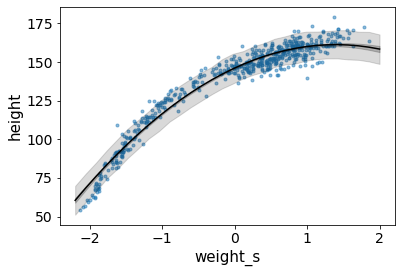

In [ ]:
az.plot_pair(
    d[["weight_s", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)
plt.plot(weight_seq, mu_mean, "k")
plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k", alpha=0.15)
plt.show()

## 4.69

In [ ]:
d['weight_s3'] = d.weight_s ** 3

def model(weight_s, weight_s2, weight_s3, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b1 = numpyro.sample("b1", dist.LogNormal(0, 1))
    b2 = numpyro.sample("b2", dist.Normal(0, 1))
    b3 = numpyro.sample("b3", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = a + b1 * weight_s + b2 * weight_s2 + b3 * weight_s3
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)

m4_6 = AutoLaplaceApproximation(model)
svi = SVI(model, m4_6, optim.Adam(0.3), Trace_ELBO(), weight_s=d.weight_s.values, weight_s2=d.weight_s2.values,
    weight_s3=d.weight_s3.values,
    height=d.height.values)
p4_6 = svi.run(key, 1000).params

100%|██████████| 1000/1000 [00:01<00:00, 681.22it/s, init loss: 5544.0449, avg. loss [951-1000]: 1668.3276]


## 4.70 - 4.71

[Text(0, 0, '6.2'),
 Text(0, 0, '20.9'),
 Text(0, 0, '35.6'),
 Text(0, 0, '50.3'),
 Text(0, 0, '65.0')]

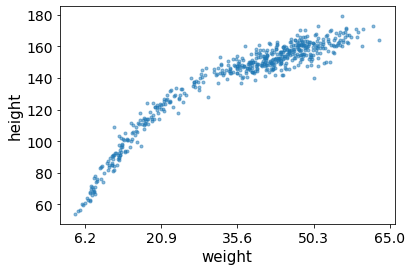

In [ ]:
ax = az.plot_pair(
    d[["weight_s", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.5}
)
ax.set(xlabel="weight", ylabel="height", xticks=[])

at = jnp.array([-2, -1, 0, 1, 2])
labels = at * d.weight.std() + d.weight.mean()
ax.set_xticks(at)
ax.set_xticklabels([round(label, 1) for label in labels])


## 4.72

In [ ]:
d = cherryblossoms = pd.read_csv('https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/cherry_blossoms.csv', sep=';')
print_summary({"year": d.year.dropna().values}, 0.89, False)
print_summary({"doy": d.doy.dropna().values}, 0.89, False)
print_summary({"temp": d.temp.dropna().values}, 0.89, False)
print_summary({"temp_upper": d.temp_upper.dropna().values}, 0.89, False)
print_summary({"temp_lower": d.temp_lower.dropna().values}, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      year   1408.00    350.88   1408.00    801.00   1882.00      2.51      2.65


                mean       std    median      5.5%     94.5%     n_eff     r_hat
       doy    104.54      6.41    105.00     93.00    113.00    111.98      1.00


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      temp      6.14      0.66      6.10      5.03      7.13     22.07      1.02


                  mean       std    median      5.5%     94.5%     n_eff     r_hat
  temp_upper      7.19      0.99      7.04      5.66      8.54     10.11      1.24


                  mean       std    median      5.5%     94.5%     n_eff     r_hat
  temp_lower      5.10      0.85      5.14      3.79      6.37     21.90      1.11



## 4.73

In [ ]:
d2 = d[d.doy.notna()]
knot_list = jnp.quantile(
    d2.year.values.astype(float), q=jnp.linspace(0, 1, num=15)
)
knot_list

DeviceArray([ 812., 1036., 1174., 1269., 1377., 1454., 1518., 1583.,
             1650., 1714., 1774., 1833., 1893., 1956., 2015.],            dtype=float32)

## 4.74

the second arg of BSpline is an N*N identity matrix tharepresnts N knots

In [ ]:
knots = jnp.pad(knot_list, (3, 3), mode='edge')
B = BSpline(knots, jnp.identity(17), 3)(d2.year.values)
B.shape[1:]

(17,)

## 4.75

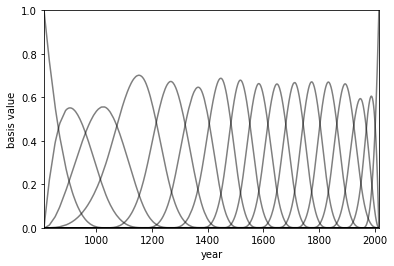

In [ ]:
plt.subplot(
    xlim=(d2.year.min(), d2.year.max()),
    ylim=(0, 1),
    xlabel="year",
    ylabel="basis value",
)
for i in range(B.shape[1]):
    plt.plot(d2.year, B[:, i], "k", alpha=0.5)

## 4.76

In [ ]:
def model(B, D):
    a = numpyro.sample('a', dist.Normal(100, 10))
    w = numpyro.sample('w', dist.Normal(0, 10).expand(B.shape[1:]))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = numpyro.deterministic('mu', a + B @ w)
    numpyro.sample('D', dist.Normal(mu, sigma), obs=D)

start = {'w': jnp.zeros(B.shape[1:])}
m4_7 = AutoLaplaceApproximation(model, init_loc_fn=init_to_value(values=start))
svi = SVI(model, m4_7, optim.Adam(1), Trace_ELBO(), B=B, D=d2.doy.values)
p4_7 = svi.run(random.PRNGKey(0), 20000).params

100%|██████████| 20000/20000 [00:02<00:00, 7633.10it/s, init loss: 2476234.7500, avg. loss [19001-20000]: 2704.7454] 


# 4.77

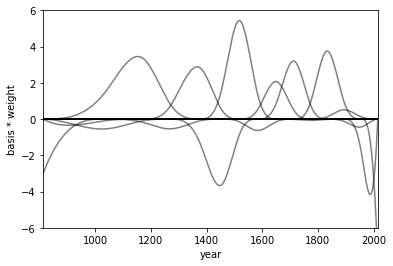

In [ ]:
post = m4_7.sample_posterior(random.PRNGKey(1), p4_7, (1000, ))
w = jnp.mean(post['w'], 0)
plt.subplot(xlim=(d2.year.min(), d2.year.max()),
    ylim=(-6, 6),
    xlabel="year",
    ylabel="basis * weight",)
for i in range(B.shape[1]):
    plt.plot(d2.year, (w[i] * B[:, i]), "k", alpha=0.5)

## 4.78

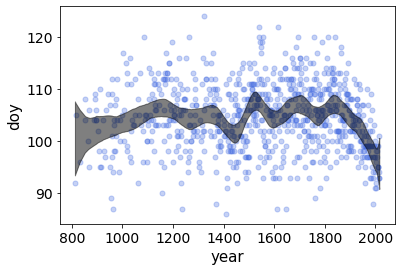

In [ ]:
mu = post["mu"]
mu_PI = jnp.percentile(mu, q=jnp.array([1.5, 98.5]), axis=0)
az.plot_pair(
    d2[["year", "doy"]].astype(float).to_dict(orient="list"),
    scatter_kwargs={"c": "royalblue", "alpha": 0.3, "markersize": 10},
)
plt.fill_between(d2.year, mu_PI[0], mu_PI[1], color="k", alpha=0.5)
plt.show()

## 4E1
$y_i$

likelihood is prob. of data given params


## 4E2

μ and σ



## 4E3

Pr(μ, σ | y) = $\frac{} {}$